# Using a custom step method for sampling from locally conjugate posterior distributions

## Introduction

Sampling methods based on Monte Carlo are extremely widely used in Bayesian inference, and PyMC3 uses a powerful version of Hamiltonian Monte Carlo (HMC) to efficiently sample from posterior distributions over many hundreds or thousands of parameters. HMC is a generic inference algorithm in the sense that you do not need to assume specific prior distributions (like an inverse-Gamma prior on the conditional variance of a regression model) or likelihood functions. In general, the product of a prior and likelihood will not easily be integrated in closed form, so we can't derive the form of the posterior with pen and paper. HMC is widely regarded as a major improvement over previous Markov chain Monte Carlo (MCMC) algorithms because it uses gradients of the model's log posterior density to make informed proposals in parameter space.

However, these gradient computations can often be expensive for models with especially complicated functional dependencies between variables and observed data. When this is the case, we may wish to find a faster sampling scheme by making use of additional structure in some portions of the model. When a number of variables within the model are *conjugate*, the conditional posterior--that is, the posterior distribution holding all other model variables fixed--can often be sampled from very easily. This suggests using a HMC-within-Gibbs step in which we alternate between using cheap conjugate sampling for variables when possible, and using more expensive HMC for the rest. 

Generally, it is not advisable to pick *any* alternative sampling method and use it to replace HMC. This combination often yields much worse performance in terms of *effective* sampling rates, even if the individual samples are drawn much more rapidly. In this notebook, we show how to implement a conjugate sampling scheme in PyMC3 and compare it against a full-HMC (or, in this case, NUTS) approach. For this case, we find that using conjugate sampling can dramatically speed up computations for a Dirichlet-multinomial model.

## Probabilistic model

To keep this notebook simple, we'll consider a relatively simple hierarchical model defined for $N$ observations of a vector of counts across $J$ outcomes::

$$\tau \sim Exp(\lambda)$$
$$\mathbf{p}_i \sim Dir(\tau )$$
$$\mathbf{x}_i \sim Multinomial(\mathbf{p}_i)$$

The index $i\in\{1,...,N\}$ represents the observation while $j\in \{1...,J\}$ indexes the outcome. The variable $\tau$ is a scalar concentration while $\mathbf{p}_i$ is a $J$-vector of probabilities drawn from a Dirichlet prior with entries $(\tau, \tau, ..., \tau)$. With fixed $\tau$ and observed data $x$, we know that $\mathbf{p}$ has a [closed-form posterior distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution#Conjugate_to_categorical/multinomial), meaning that we can easily sample from it. Our sampling scheme will alternate between using the No-U-Turn sampler (NUTS) on $\tau$ and drawing from this known conditional posterior distribution for $\mathbf{p}_i$. We will assume a fixed value for $\lambda$.

## Implementing a custom step method

Adding a conjugate sampler as part of our compound sampling approach is straightforward: we define a new step method that examines the current state of the Markov chain approximation and modifies it by adding samples drawn from the conjugate posterior. 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from pymc3.distributions.transforms import stick_breaking
from pymc3.model import modelcontext
from pymc3.step_methods.arraystep import BlockedStep

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

First, we need a method for sampling from a Dirichlet distribution. The built in `numpy.random.dirichlet` can only handle 2D input arrays, and we might like to generalize beyond this in the future. Thus, I have created a function for sampling from a Dirichlet distribution with parameter array `c` by using representing it as a normalized sum of Gamma random variables. More detail about this is given [here](https://en.wikipedia.org/wiki/Dirichlet_distribution#Gamma_distribution).

In [2]:
def sample_dirichlet(c):
    """
    Samples Dirichlet random variables which sum to 1 along their last axis.
    """
    gamma = np.random.gamma(c)
    p = gamma / gamma.sum(axis=-1, keepdims=True)
    return p

Next, we define the step object used to replace NUTS for part of the computation. It must have a `step` method that receives a dict called `point` containing the current state of the Markov chain. We'll modify it in place.

There is an extra complication here as PyMC3 does not track the state of the Dirichlet random variable in the form $\mathbf{p}=(p_1, p_2 ,..., p_J)$ with the constraint $\sum_j p_j = 1$. Rather, it uses an inverse stick breaking transformation of the variable which is easier to use with NUTS. This transformation removes the constraint that all entries must sum to 1 and are positive.

In [3]:
class ConjugateStep(BlockedStep):
    def __init__(self, var, counts, concentration):
        self.vars = [var]
        self.counts = counts
        self.name = var.name
        self.conc_prior = concentration

    def step(self, point):
        # Since our concentration parameter is going to be log-transformed
        # in point, we invert that transformation so that we
        # can get conc_posterior = conc_prior + counts
        conc_posterior = np.exp(point[self.conc_prior.transformed.name]) + self.counts
        draw = sample_dirichlet(conc_posterior)

        # Since our new_p is not in the transformed / unconstrained space,
        # we apply the transformation so that our new value
        # is consistent with PyMC3's internal representation of p
        point[self.name] = stick_breaking.forward_val(draw)

        return point

## Simulated data

We'll try out the sampler on some simulated data. Fixing $\tau=0.5$, we'll draw 500 observations of a 10 dimensional Dirichlet distribution.

In [4]:
J = 10
N = 500

ncounts = 20
tau_true = 0.5
alpha = tau_true * np.ones([N, J])
p_true = sample_dirichlet(alpha)
counts = np.zeros([N, J])

for i in range(N):
    counts[i] = np.random.multinomial(ncounts, p_true[i])
print(counts.shape)

(500, 10)


## Comparing partial conjugate with full NUTS sampling

We don't have any closed form expression for the posterior distribution of $\tau$ so we will use NUTS on it. In the code cell below, we fit the same model using 1) conjugate sampling on the probability vectors with NUTS on $\tau$, and 2) NUTS for everything.

In [5]:
traces = []
models = []
names = ["Partial conjugate sampling", "Full NUTS"]

for use_conjugate in [True, False]:
    with pm.Model() as model:
        tau = pm.Exponential("tau", lam=1, testval=1.0)
        alpha = pm.Deterministic("alpha", tau * np.ones([N, J]))
        p = pm.Dirichlet("p", a=alpha)

        if use_conjugate:
            step = [ConjugateStep(p.transformed, counts, tau)]
        else:
            # If we use the conjugate sampling, we don't need to define the likelihood
            # as it's already taken into account in our custom step method
            x = pm.Multinomial("x", n=counts.sum(axis=-1), p=p, observed=counts)
            step = []

        trace = pm.sample(step=step, chains=2, cores=1)
        traces.append(trace)

    assert all(pm.summary(trace)["r_hat"] < 1.1)
    models.append(model)

Sequential sampling (2 chains in 1 job)
CompoundStep
>ConjugateStep: [p]
>NUTS: [tau]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/ckrapu/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Sequential sampling (2 chains in 1 job)
NUTS: [p, tau]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 364 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7173250753462687, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/Users/ckrapu/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


We see that the runtimes for the partially conjugate sampling are much lower, though this can be misleading if the samples have high autocorrelation or the chains are mixing very slowly. We also see that there are a few divergences in the NUTS-only trace.

We want to make sure that the two samplers are converging to the same estimates. The posterior histogram and trace plot below show that both essentially converge to $\tau$ within reasonable posterior uncertainty credible intervals. We can also see that the trace plots lack any obvious autocorrelation as they are mostly indistinguishable from white noise.

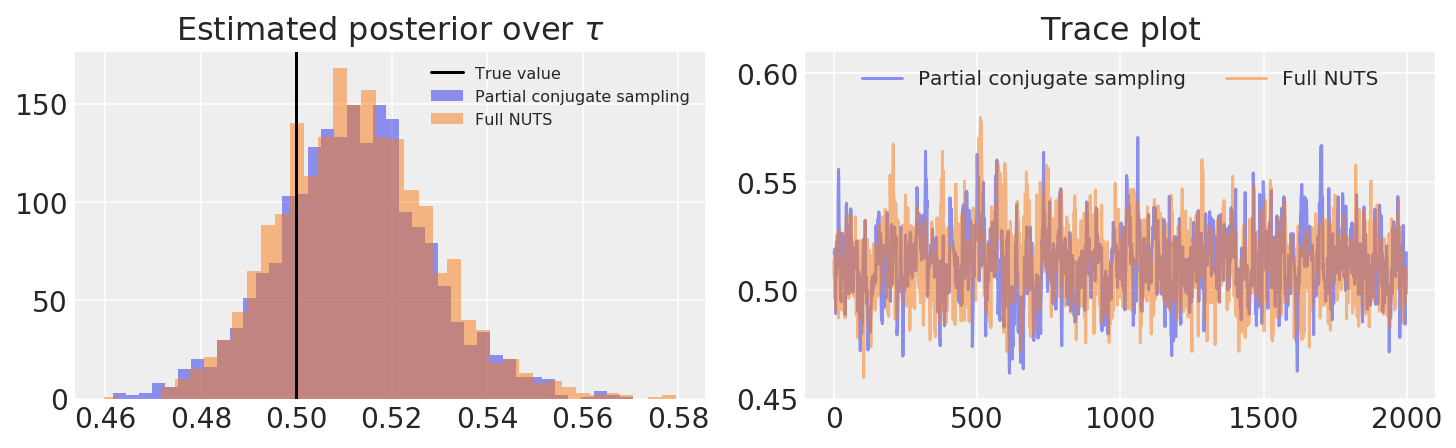

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
[axes[0].hist(trace["tau"], bins=40, alpha=0.5, label=names[i]) for i, trace in enumerate(traces)]
axes[0].set_title("Estimated posterior over $\\tau$"), axes[1].set_title("Trace plot")
axes[0].axvline(0.5, label="True value", color="k")
plt.sca(axes[0]), plt.legend(loc="upper right", fontsize=8)

[axes[1].plot(trace["tau"], alpha=0.5, label=names[i]) for i, trace in enumerate(traces)]
plt.sca(axes[1]), plt.legend(fontsize=10, ncol=2, loc="upper center"), plt.ylim(0.45, 0.61);

We want to avoid comparing sampler effectiveness in terms of raw samples per second. If a sampler works quickly per sample but generates highly correlated samples, the effective sample size (ESS) is diminished. Since our posterior analyses are critically dependent on the effective sample size, we should examine this latter quantity instead.

This model includes $500\times 10=5000$ probability values for the 500 Dirichlet random variables. Let's calculate the effective sample size for each of these 5000 entries and generate a histogram for each sampling method:

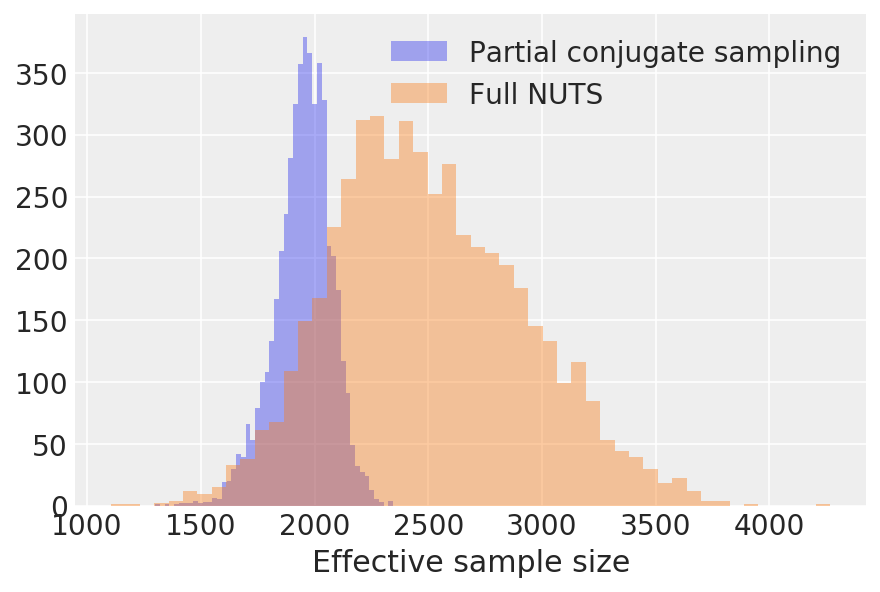

In [7]:
summaries_p = []
for trace, model in zip(traces, models):
    with model:
        summaries_p.append(pm.summary(trace, var_names="p"))

[plt.hist(s["ess_mean"], bins=50, alpha=0.4, label=names[i]) for i, s in enumerate(summaries_p)]
plt.legend(), plt.xlabel("Effective sample size");

Interestingly, we see that while the mode of the ESS histogram is larger for the full NUTS run, the minimum ESS appears to be lower. Since our inferences are often constrained by the of the worst-performing part of the Markov chain, the minimum ESS is of interest.

In [8]:
print("Minimum effective sample sizes across all entries of p:")
print({names[i]: s["ess_mean"].min() for i, s in enumerate(summaries_p)})

Minimum effective sample sizes across all entries of p:
{'Partial conjugate sampling': 1299.0, 'Full NUTS': 1105.0}


Here, we can see that the conjugate sampling scheme gets more effective samples in the worst case. However, the disparity is even more striking when we consider the effective sampling *rate*.

In [9]:
print("Minimum ESS/second across all entries of p:")
print(
    {names[i]: s["ess_mean"].min() / traces[i].report.t_sampling for i, s in enumerate(summaries_p)}
)

Minimum ESS/second across all entries of p:
{'Partial conjugate sampling': 52.97215865506974, 'Full NUTS': 3.0349078337182966}


The partial conjugate sampling scheme is over 10X faster in terms of worst-case ESS rate!

As a final check, we also want to make sure that the probability estimates are the same for both samplers. In the plot below, we can see that the blue dots relating partial conjugate versus full NUTS fall neatly on the 1-1 line indicating equality. These are also unsurprisingly highly correlated with the ground truth values used to generate the simulated dataset.

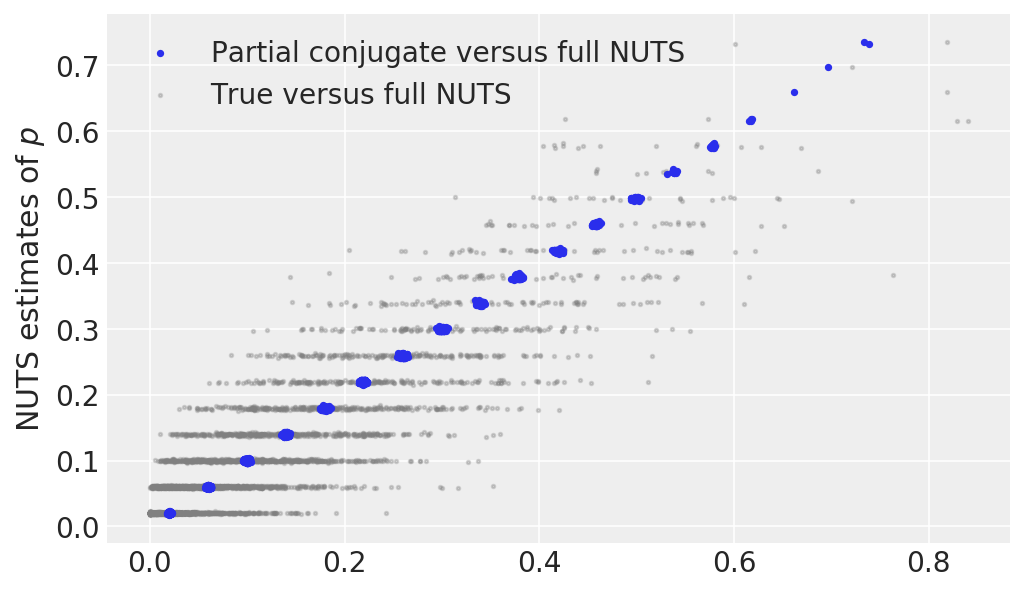

In [10]:
plt.figure(figsize=(7, 4))
plt.scatter(
    summaries_p[0]["mean"],
    summaries_p[1]["mean"],
    s=7,
    label="Partial conjugate versus full NUTS",
    zorder=2,
)
plt.scatter(
    p_true.ravel(),
    summaries_p[1]["mean"],
    s=3,
    alpha=0.3,
    color="0.5",
    label="True versus full NUTS",
    zorder=1,
)
plt.legend(), plt.ylabel("NUTS estimates of $p$");

* This notebook was written by Christopher Krapu on October 26, 2020.

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy 1.18.1
arviz 0.9.0
pymc3 3.9.3
last updated: Wed Oct 28 2020 

CPython 3.7.2
IPython 7.3.0
watermark 2.0.2
